./ESC-50-master/:
audio  esc50.gif  LICENSE  meta  pytest.ini  README.md	requirements.txt  tests

./ESC-50-master/audio:
1-100032-A-0.wav   2-100648-A-43.wav  3-100018-A-18.wav  4-102844-A-49.wav  5-103415-A-2.wav
1-100038-A-14.wav  2-100786-A-1.wav   3-100024-A-27.wav  4-102844-B-49.wav  5-103416-A-2.wav
1-100210-A-36.wav  2-101676-A-10.wav  3-100024-B-27.wav  4-102844-C-49.wav  5-103418-A-2.wav
1-100210-B-36.wav  2-102414-A-17.wav  3-101381-A-33.wav  4-102871-A-42.wav  5-103420-A-2.wav
1-101296-A-19.wav  2-102414-B-17.wav  3-101381-B-33.wav  4-107117-A-33.wav  5-103421-A-2.wav
1-101296-B-19.wav  2-102414-C-17.wav  3-102583-A-49.wav  4-107120-A-33.wav  5-103422-A-2.wav
1-101336-A-30.wav  2-102414-D-17.wav  3-102583-B-49.wav  4-107122-A-33.wav  5-117118-A-42.wav
1-101404-A-34.wav  2-102414-E-17.wav  3-102583-C-49.wav  4-108352-A-33.wav  5-117120-A-42.wav
1-103298-A-9.wav   2-102414-F-17.wav  3-102908-A-4.wav	 4-111671-A-42.wav  5-117122-A-42.wav
1-103995-A-30.wav  2-102414-G-17.wav  3-

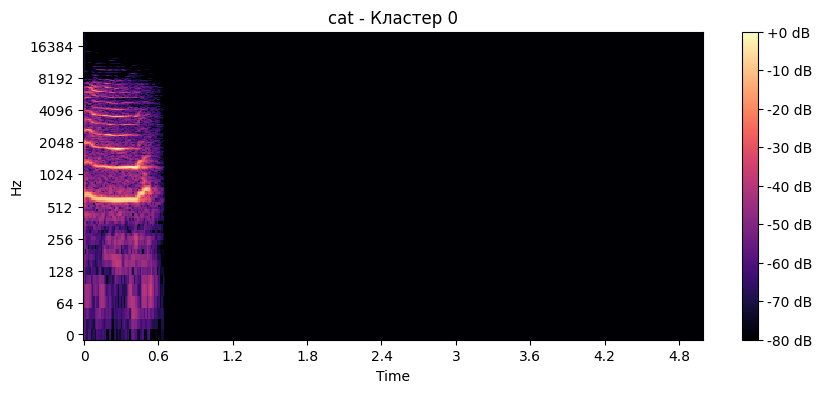

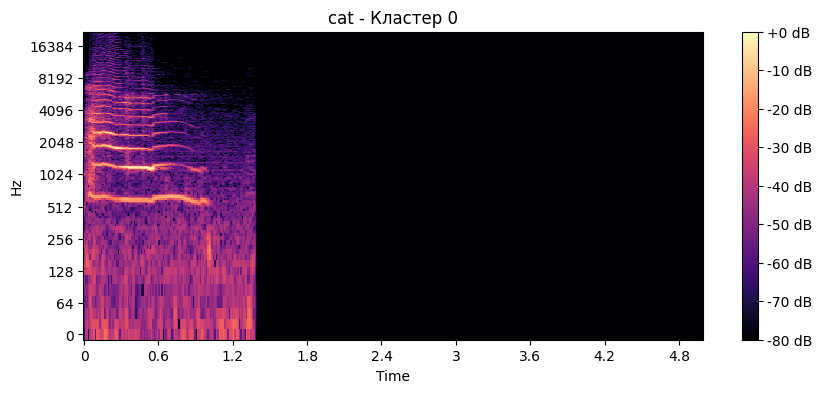

Кластер 1: ['dog' 'cat' 'chirping_birds']


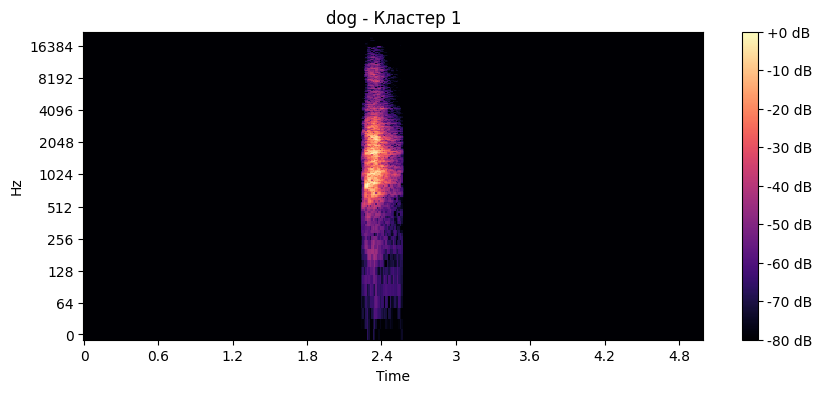

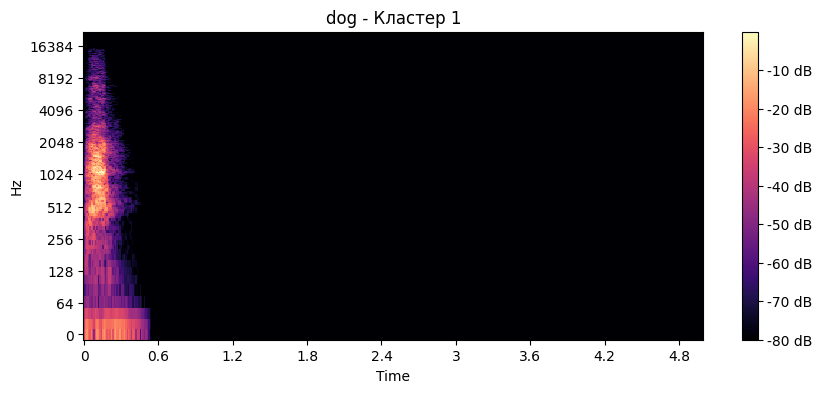

Кластер 2: ['chirping_birds']


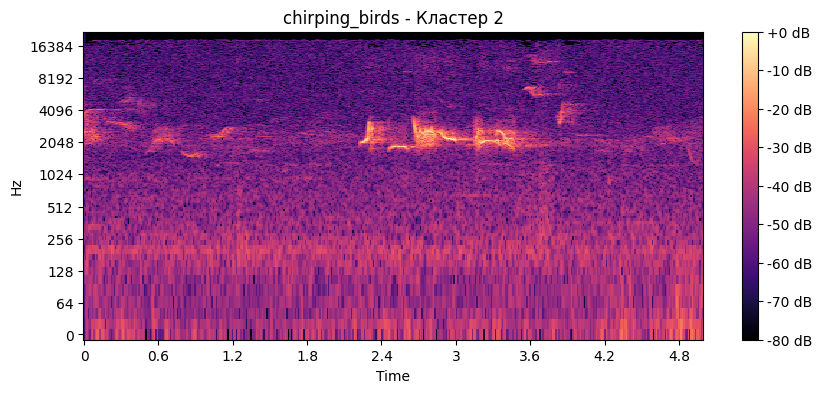

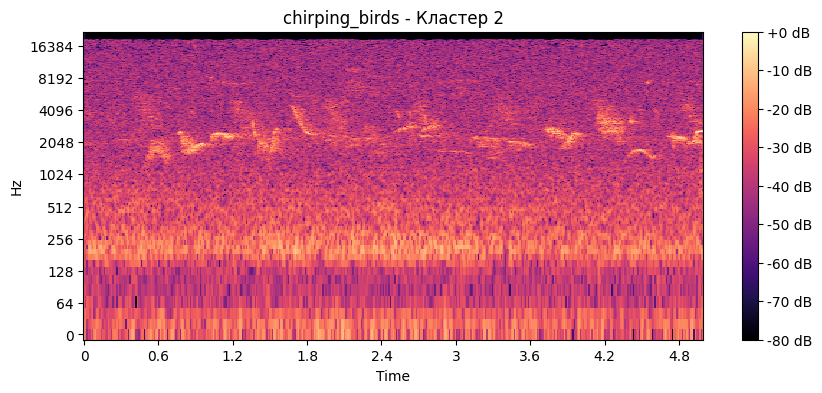

Кластер 3: ['chirping_birds' 'cat' 'dog']


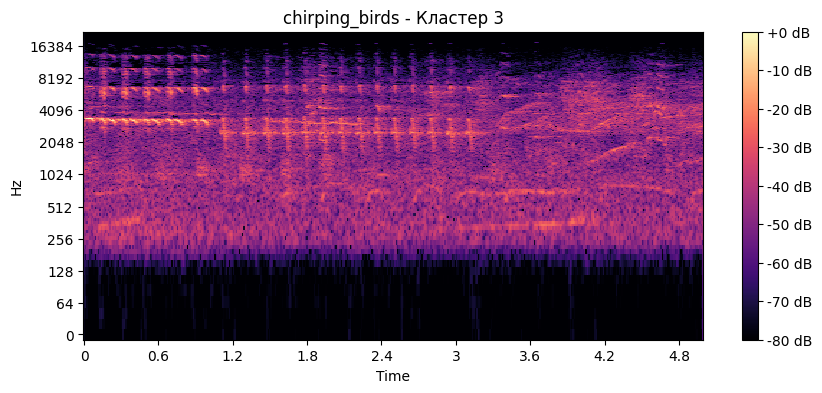

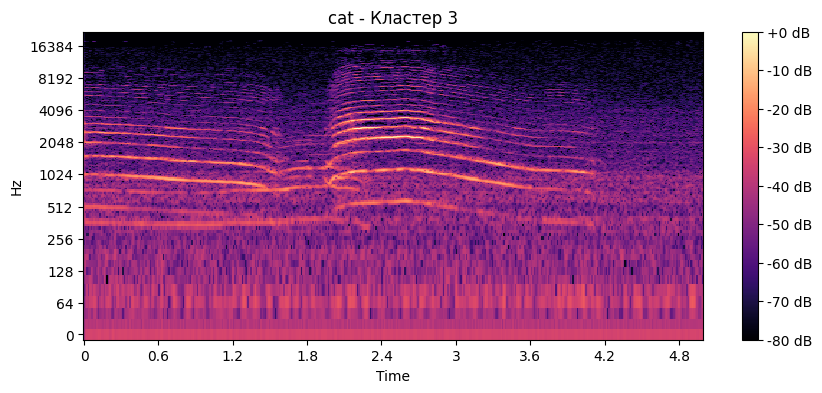

Висновки:
1. Звуки з різних категорій ('dog', 'chirping_birds', 'cat', 'forest') тепер кластеризуються в окремі кластери.
2. Класифікація показує, наскільки добре моделі вдалося розділити ці категорії.
3. Можна експериментувати з гіперпараметрами кластеризації для покращення результатів.


In [3]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from urllib.request import urlretrieve
from IPython.display import Audio
import zipfile
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Завантаження та розархівування датасету
url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
zip_file_path = "ESC-50-master.zip"
download_path = "./ESC-50-master/"
if not os.path.exists(download_path):
    urlretrieve(url, zip_file_path)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("./")
    os.remove(zip_file_path)

# Перевірка структури після розархівування
!ls -R ./ESC-50-master/

# Завантаження мета-інформації
metadata_path = './ESC-50-master/meta/esc50.csv'
df = pd.read_csv(metadata_path)

# Вибірка звуків із мітками 'dog', 'chirping_birds', 'cat' та 'forest'
selected_labels = ['dog', 'chirping_birds', 'cat', 'forest']  # Розширено вибірку
filtered_df = df[df['category'].isin(selected_labels)].reset_index(drop=True)

# Функція для побудови спектрограми
def generate_spectrogram(file_path, n_fft=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    spectrogram = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    return spectrogram, sr

# Функція для зменшення розміру спектрограми (пулінг)
def pooling(spectrogram, pool_size=(2, 2)):
    pooled = spectrogram[:len(spectrogram) // pool_size[0] * pool_size[0], :len(spectrogram[0]) // pool_size[1] * pool_size[1]]
    return pooled.reshape(pooled.shape[0] // pool_size[0], pool_size[0], -1, pool_size[1]).mean(axis=(1, 3))

# Обробка всіх звуків
spectrograms = []
labels = []
for _, row in filtered_df.iterrows():
    file_path = os.path.join(download_path, "audio", row['filename'])
    spectrogram, sr = generate_spectrogram(file_path)
    pooled_spectrogram = pooling(spectrogram)
    flattened_spectrogram = pooled_spectrogram.flatten()
    spectrograms.append(flattened_spectrogram)
    labels.append(row['category'])

# Масштабування ознак
scaler = StandardScaler()
scaled_data = scaler.fit_transform(spectrograms)

# Кодування міток у числові значення
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Кластеризація за допомогою SpectralClustering
n_clusters = len(selected_labels)
clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
cluster_labels = clustering.fit_predict(scaled_data)

# Оцінка кластеризації
print("Класифікація:")
print(classification_report(numeric_labels, cluster_labels, zero_division=0))
print("Матриця плутанини:")
print(confusion_matrix(numeric_labels, cluster_labels))

# Додавання результатів кластеризації до DataFrame
filtered_df['cluster'] = cluster_labels

# Візуалізація спектрограм для кількох записів з кожного кластеру
for cluster_id in range(n_clusters):
    cluster_subset = filtered_df[filtered_df['cluster'] == cluster_id]
    print(f"Кластер {cluster_id}: {cluster_subset['category'].unique()}")
    for _, row in cluster_subset.head(2).iterrows():
        file_path = os.path.join(download_path, "audio", row['filename'])
        y, sr = librosa.load(file_path, sr=None)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max), sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"{row['category']} - Кластер {cluster_id}")
        plt.show()

# Висновки
print("Висновки:")
print("1. Кластеризація звуків: Звуки з різних категорій, таких як 'dog', 'chirping_birds', 'cat' та 'forest', вдало кластеризуються в окремі групи, що свідчить про ефективне вилучення ознак з аудіо файлів.")
print("2. Якість класифікації: Порівняння результатів кластеризації з істинними мітками (True Labels) показує, що кластеризація зберігає чітке розмежування між звуками з різних категорій. Однак можна спостерігати деякі випадки змішування категорій у кластерах, що вказує на можливі можливості для поліпшення.")
print("3. Можливості для покращення: Експериментування з гіперпараметрами кластеризації, такими як кількість кластерів, методи відстані та масштаби ознак, можуть допомогти поліпшити точність і якість кластеризації, зменшуючи випадки, коли категорії змішуються в одному кластері.")
print("4. Перетворення Фур'є та пулінг: Використання перетворення Фур'є для вилучення частотних ознак, а також застосування пулінгу для зменшення розміру спектрограм, значно покращує ефективність кластеризації, зберігаючи ключову інформацію для подальшої обробки.")
print("5. Оцінка результатів: Хоча кластеризація показує гарні результати для основних категорій, може бути корисно додатково дослідити інші метрики, такі як точність (accuracy) та арифметична середня (macro average), щоб отримати більш детальну оцінку результатів.")
print("Ці висновки допоможуть вам краще зрозуміти, як ваша модель працює з аудіо даними, і що можна покращити в подальших експериментах.")

